In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import io
import mysql.connector as con
from abc import ABC,abstractmethod

In [2]:
class Connection:
    @staticmethod
    def getConnection():
        try:
            db_connection = con.connect(  # Creating Connection
                host="localhost",
                user="root",
                password="alpha",
                database="electricity_billing_db"
            )
            return db_connection
        except con.Error as e:
            print(f"Error connecting to the database: {e}")
            return None


In [3]:
class User(ABC):
    def __init__(self):
        pass

In [4]:
class Admin(User):
    def __init__(self, uid, uname, pin, fname, address, role):
        self.uid = uid
        self.uname = uname
        self.pin = pin
        self.fname = fname
        self.address = address
        self.role = role

    def add_Customer(self, user_data, meter_data):
        try:
            db_con = Connection.getConnection()
            cursor = db_con.cursor()
            query = "INSERT INTO users (user_id, username, password, full_name, address, role, mail_id, contact_no) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"
            q = "INSERT INTO meters (user_id, meter_number, meter_type, fixed_charges) VALUES (%s, %s, %s, %s)"
            
            cursor.execute(query, user_data)
            cursor.execute(q, meter_data)
            db_con.commit()

            print("\n" + "=" * 60)
            print("{:^60}".format("Customer Added Successfully!"))
            print("=" * 60)

        except Exception as e:
            print(f"\n{'!' * 60}\nError Occurred: {e}\n{'!' * 60}")
        
        finally:
            db_con.close()

    def generate_bill(self, uid, user_details):
        month_data = {
            1: "January", 2: "February", 3: "March", 4: "April",
            5: "May", 6: "June", 7: "July", 8: "August",
            9: "September", 10: "October", 11: "November", 12: "December"
        }

        try:
            db_con = Connection.getConnection()
            cursor = db_con.cursor(dictionary=True)
            pointer = db_con.cursor(dictionary=True)

            cursor.execute("SELECT * FROM meter_readings WHERE user_id=%s;", (uid,))
            mReading = cursor.fetchone()

            pointer.execute("SELECT * FROM meters WHERE user_id=%s;", (uid,))
            meter = pointer.fetchone()

            pastReading = mReading["current_reading"]
            charges = meter["fixed_charges"]
            mType = meter["meter_type"]
            mNumber = meter["meter_number"]

            while True:
                try:
                    currentReading = int(input("→ Enter Current Meter Reading: "))
                    if currentReading <= pastReading:
                        print("\n Current reading must be greater than previous reading. Try again.\n")
                        continue

                    year = int(input("→ Enter Year: "))
                    month_int = int(input("→ Enter Month (1-12): "))
                    date = int(input("→ Enter Date: "))
                    bid = input("→ Enter Bill ID: ")
                    units_consumed = currentReading - pastReading
                    totalAmount = (units_consumed * 10) + charges
                    bill_date = f"{year}-{month_int:02d}-{date:02d}"

                    print("\n" + "=" * 60)
                    print("{:^60}".format("ELECTRICITY BILL"))
                    print("=" * 60)
                    print(f"Customer: {user_details['full_name']} (Username: {user_details['username']})")
                    print(f"Bill Number: {bid} | Date: {bill_date}")
                    print(f"Meter: {mNumber} | Type: {mType}")
                    print(f"Previous Reading: {pastReading} | Current Reading: {currentReading}")
                    print(f"Units Consumed: {units_consumed} | Fixed Charges: ₹{charges}")
                    print("-" * 60)
                    print(f"Total Amount Due: ₹{totalAmount:.2f}")
                    print("=" * 60)

                    update_query = "UPDATE meter_readings SET past_reading=%s, current_reading=%s, reading_date=%s WHERE user_id=%s;"
                    cursor.execute(update_query, (pastReading, currentReading, bill_date, uid))

                    insert_query = "INSERT INTO current_year_bills (user_id, bill_id, month, unit_consumed, amount, status, bill_date) VALUES (%s, %s, %s, %s, %s, %s, %s)"
                    cursor.execute(insert_query, (uid, bid, month_data[month_int], units_consumed, totalAmount, "pending", bill_date))

                    db_con.commit()
                    print("\n Bill generated and saved successfully!\n")
                    break

                except ValueError:
                    print(" Invalid input. Please enter numeric values where required.")

        except Exception as e:
            print(f"\n Error: {e}\n")

        finally:
            db_con.close()

    def view_pending_bills(self):
        try:
            db_con = Connection.getConnection()
            cursor = db_con.cursor()

            cursor.execute("SELECT * FROM current_year_bills WHERE status=%s;", ("pending",))
            data = cursor.fetchall()

            if data:
                columns = [desc[0] for desc in cursor.description]
                df = pd.DataFrame(data, columns=columns)
                print("\n" + "=" * 60)
                print("{:^60}".format("PENDING BILLS"))
                print("=" * 60)
                print(df.to_string(index=False))
            else:
                print("\n No pending bills found!\n")

        except Exception as e:
            print(f"\n Error: {e}\n")

        finally:
            cursor.close()
            db_con.close()

    def months_analysis(self):
        try:
            db_con = Connection.getConnection()
            cursor = db_con.cursor()

            cursor.execute("SELECT month, SUM(unit_consumed) FROM current_year_bills GROUP BY month;")
            data = cursor.fetchall()

            if not data:
                print("\n No consumption data available.")
                return

            months, units = zip(*data)
            plt.figure(figsize=(10, 6))
            plt.bar(months, units, color='skyblue', edgecolor='black')
            plt.title('Monthly Electricity Consumption', fontsize=16, weight='bold')
            plt.xlabel('Month', fontsize=12)
            plt.ylabel('Units Consumed', fontsize=12)
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"\n Error: {e}\n")

        finally:
            cursor.close()
            db_con.close()

    def hl_users_analysis(self):
        try:
            db_con = Connection.getConnection()
            cursor = db_con.cursor()

            cursor.execute("SELECT user_id, SUM(unit_consumed) as total_consumed FROM current_year_bills GROUP BY user_id ORDER BY total_consumed DESC LIMIT 5;")
            data = cursor.fetchall()

            if not data:
                print("\n No data for highest consumers.")
                return

            df = pd.DataFrame(data, columns=["User ID", "Units Consumed"])
            print("\n" + "=" * 60)
            print("{:^60}".format("TOP 5 HIGHEST CONSUMERS"))
            print("=" * 60)
            print(df.to_string(index=False))

            
            user_ids = df["User ID"]
            units = df["Units Consumed"]
            positions = range(len(user_ids)) 
            
            plt.figure(figsize=(10, 6))
            plt.bar(positions, units, color='green', edgecolor='black', width=0.5)
            plt.title("Top 5 Consumers", fontsize=16, weight='bold')
            plt.xticks(positions, user_ids)
            plt.xlabel("User ID", fontsize=12)
            plt.ylabel("Units Consumed", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"\n Error: {e}\n")

        finally:
            cursor.close()
            db_con.close()

    def view_complain(self):
        try:
            db_con = Connection.getConnection()
            cursor = db_con.cursor()

            cursor.execute("SELECT * FROM complain")
            data = cursor.fetchall()

            if not data:
                print("\nNo complaints found.")
                return

            df = pd.DataFrame(data, columns=["User ID", "Complaint ID", "Title", "Status", "Description"])

            while True:
                print("\n" + "=" * 60)
                print("{:^60}".format("COMPLAINT LIST"))
                print("=" * 60)
                print(df.drop(columns=["Description"]).to_string(index=False))

                try:
                    cid = int(input("\n→ Enter Complaint ID to view details (0 to Exit): "))
                except ValueError:
                    print("Enter a valid integer.")
                    continue

                if cid == 0:
                    print("\n Exiting complaint view.")
                    break

                complaint = df[df["Complaint ID"] == cid]
                if complaint.empty:
                    print("Complaint ID not found.")
                    continue

                print("\n" + "-" * 60)
                print(complaint[["Complaint ID", "Title", "Description", "Status"]].to_string(index=False))
                print("-" * 60)

                try:
                    choice = int(input("\n1️. Mark as Resolved  |  2️. Refresh  |  0️. Exit\n→ Enter choice: "))
                except ValueError:
                    print(" Invalid choice.")
                    continue

                if choice == 0:
                    break
                elif choice == 1:
                    cursor.execute("DELETE FROM complain WHERE c_id=%s", (cid,))
                    db_con.commit()
                    df = df[df["Complaint ID"] != cid]
                    print("\n Complaint marked as resolved and removed.")
                elif choice == 2:
                    print("\n Refreshing complaint list...")
                else:
                    print("Invalid option.")

        except Exception as e:
            print(f"\n Error: {e}\n")

        finally:
            cursor.close()
            db_con.close()


In [5]:
class AdminDashboard(Admin):
    def __init__(self):
        print("\n" + "-" * 50)
        print("ADMIN DASHBOARD".center(50))
        print("-" * 50)
        while True:
            try:
                ch = int(input(
                    "\nSelect an Option:\n"
                    "1. Add Customer\n"
                    "2. Generate Bill\n"
                    "3. View Pending Bills\n"
                    "4. Month-wise Analysis\n"
                    "5. User's Analysis\n"
                    "6. View Complaints\n"
                    "7. Exit\n"
                    "Enter your choice: "
                ))

                if ch == 1:
                    try:
                        print("\n" + "=" * 40)
                        print("ADD NEW CUSTOMER".center(40))
                        print("=" * 40)
                        uid = int(input("Enter User ID: "))
                        uname = input("Enter Username: ").strip()
                        password = input("Enter Password: ").strip()
                        fname = input("Enter Full Name: ").strip()
                        add = input("Enter Address: ").strip()
                        role = input("Enter Role: ").strip()
                        mail = input("Enter Email: ").strip()
                        con = input("Enter Contact Number: ").strip()
                        meter_number = input("Enter Meter Number: ").strip()
                        meter_type = input("Enter Meter Type (residential/commercial/other): ").strip().lower()

                        if meter_type == "residential":
                            fixed_charges = 550
                        elif meter_type == "commercial":
                            fixed_charges = 675
                        else:
                            fixed_charges = 680

                        self.add_Customer(
                            (uid, uname, password, fname, add, role, mail, con),
                            (uid, meter_number, meter_type, fixed_charges)
                        )
                        print("\nCustomer added successfully!")

                    except ValueError:
                        print("\nInvalid input! Please enter correct data types.")
                    except Exception as e:
                        print(f"\nAn error occurred: {e}")

                elif ch == 2:
                    print("\n" + "=" * 40)
                    print("GENERATE BILL".center(40))
                    print("=" * 40)
                    while True:
                        try:
                            us_id = int(input("Enter User ID: "))
                            user_details = CheckUser.user_details(us_id)
                            if user_details:
                                self.generate_bill(us_id, user_details)
                                break
                            else:
                                print("Customer not found. Please try again.")
                        except ValueError:
                            print("Invalid User ID! Please enter a valid number.")
                        except Exception as e:
                            print(f"An error occurred: {e}")

                elif ch == 3:
                    try:
                        self.view_pending_bills()
                    except Exception as e:
                        print(f"Error fetching pending bills: {e}")

                elif ch == 4:
                    print("\n" + "=" * 40)
                    print("MONTH-WISE CONSUMPTION ANALYSIS".center(40))
                    print("=" * 40)
                    try:
                        self.months_analysis()
                    except Exception as e:
                        print(f"Error during analysis: {e}")

                elif ch == 5:
                    print("\n" + "=" * 40)
                    print("USER'S ANALYSIS".center(40))
                    print("=" * 40)
                    try:
                        self.hl_users_analysis()
                    except Exception as e:
                        print(f"Error during user's analysis: {e}")

                elif ch == 6:
                    print("\n" + "=" * 40)
                    print("VIEW COMPLAINTS".center(40))
                    print("=" * 40)
                    try:
                        self.view_complain()
                    except Exception as e:
                        print(f"Error fetching complaints: {e}")

                elif ch == 7:
                    print("\nExiting Admin Dashboard. Goodbye!\n")
                    break

                else:
                    print("\nInvalid choice! Please select a valid option.")

            except ValueError:
                print("\nPlease enter a valid number for the choice.")
            except Exception as e:
                print(f"\nAn unexpected error occurred: {e}")


In [6]:
class Customer(User):
    def __init__(self, uid, uname, pin, fname, address, role, mail, mo):
        self.uid = uid
        self.uname = uname
        self.pin = pin
        self.fname = fname
        self.address = address
        self.role = role
        self.mail = mail
        self.contact = mo

    def view_Bill(self, user):
        try:
            id = user.uid
            db_con = Connection.getConnection()
            cursor = db_con.cursor()

            query = "SELECT * FROM current_year_bills WHERE user_id = %s AND status = %s;"
            cursor.execute(query, (id, "pending"))
            bill_Data = cursor.fetchone()

            if bill_Data:
                try:
                    q = "SELECT * FROM meters WHERE user_id = %s;"
                    que = "SELECT * FROM meter_readings WHERE user_id = %s;"

                    mdcursor = db_con.cursor()
                    mrcursor = db_con.cursor()

                    mdcursor.execute(q, (id,))
                    meter_details = mdcursor.fetchone()

                    mrcursor.execute(que, (id,))
                    meter_readings = mrcursor.fetchone()

                    print("\n" + "=" * 50)
                    print("{:^50}".format("ELECTRICITY BILL RECEIPT"))
                    print("=" * 50)
                    print(f"  BILL ID        : {bill_Data[1]}")
                    print(f"  Bill Date      : {bill_Data[6]}")
                    print(f"  Billing Month  : {bill_Data[2]}")
                    print("-" * 50)
                    print(f"  Customer Id    : {user.uname}")
                    print(f"  Customer Name  : {user.fname}")
                    print(f"  Address        : {user.address}")
                    print(f"  Contact No.    : {user.contact}")
                    print("-" * 50)
                    print(f"  Meter No.      : {meter_details[1]}")
                    print(f"  Meter Type     : {meter_details[2]}")
                    print(f"  Fixed Charges  : ₹{meter_details[3]}")
                    print("-" * 50)
                    print(f"  Past Reading   : {meter_readings[1]} units")
                    print(f"  Current Reading: {meter_readings[2]} units")
                    print(f"  Reading Date   : {meter_readings[3]}")
                    print("-" * 50)
                    print(f"  Units Consumed : {bill_Data[3]} units")
                    print(f"  Amount Due     : ₹{bill_Data[4]}")
                    print(f"  Status         : {bill_Data[5]}")
                    print("=" * 50 + "\n")

                    self.show_Analysis(user, bill_Data)
                except Exception as e:
                    print("Error fetching meter details:", e)
            else:
                print("\nNo Pending Bills Found!\n")
        except Exception as e:
            print("Error fetching bill details:", e)
        finally:
            db_con.close()

    def show_Analysis(self, user, bill_data):
        try:
            db_con = Connection.getConnection()
            cycursor = db_con.cursor()
            pycursor = db_con.cursor()

            query = "SELECT month, unit_consumed FROM current_year_bills WHERE user_id = %s;"
            cycursor.execute(query, (user.uid,))
            cy_Data = cycursor.fetchall()

            if not cy_Data:
                print("No current year data found!")
                return

            df1 = pd.DataFrame(cy_Data, columns=["month", "unit_consumed"])

            que = "SELECT * FROM bills WHERE user_id=%s;"
            pycursor.execute(que, (user.uid,))
            py_Data = pycursor.fetchone()

            if py_Data:
                try:
                    csv_data = io.BytesIO(py_Data[2])
                    df2 = pd.read_csv(csv_data, skiprows=1, names=["month", "unit_consumed"])

                    df1["month"] = pd.to_datetime(df1["month"], format="%B")
                    df2["month"] = pd.to_datetime(df2["month"], format="%B")

                    max_month = df1["month"].max().month
                    df2 = df2[df2["month"].dt.month <= max_month]

                    df1["month"] = df1["month"].dt.strftime("%B")
                    df2["month"] = df2["month"].dt.strftime("%B")

                    bar_width = 0.4
                    months = df1["month"]
                    x = np.arange(len(months))

                    plt.figure(figsize=(10, 5))
                    plt.bar(x + bar_width / 2, df2["unit_consumed"], width=bar_width, label="Past Year", color="orange")
                    plt.bar(x - bar_width / 2, df1["unit_consumed"], width=bar_width, label="Current Year", color="blue")

                    plt.xlabel("Month")
                    plt.ylabel("Units Consumed")
                    plt.title("Electricity Consumption Comparison")
                    plt.xticks(x, months, rotation=45)
                    plt.legend()
                    plt.show()

                    self.generate_bill_pdf(user, bill_data, df1, df2)
                except Exception as e:
                    print("Error processing past year data:", e)
            else:
                print("No past year data found!")
        except Exception as e:
            print("Error fetching analysis data:", e)
        finally:
            db_con.close()

    def generate_bill_pdf(self, user, bill_data, df1, df2):
        try:
            pdf_filename = f"Bill_{user.uid}.pdf"
            c = canvas.Canvas(pdf_filename, pagesize=letter)

            c.setFont("Helvetica-Bold", 16)
            c.drawString(200, 750, "Electricity Bill Receipt")

            c.setFont("Helvetica", 12)
            c.drawString(50, 720, f"Name: {user.uname}")
            c.drawString(50, 700, f"Address: {user.address}")
            c.drawString(50, 680, f"Contact: {user.contact}")
            c.drawString(50, 650, f"Bill ID: {bill_data[1]}")
            c.drawString(50, 630, f"Bill Month: {bill_data[2]}")
            c.drawString(50, 610, f"Units Consumed: {bill_data[3]}")
            c.drawString(50, 590, f"Amount Due: {bill_data[4]}")
            c.drawString(50, 570, f"Status: {bill_data[5]}")
            c.drawString(50, 550, f"Bill Date: {bill_data[6]}")

            plt.figure(figsize=(6, 3))
            months = df1["month"].tolist()
            x = np.arange(len(months))
            bar_width = 0.35

            plt.bar(x - bar_width / 2, df1["unit_consumed"], width=bar_width, label="Current Year", color="blue")
            plt.bar(x + bar_width / 2, df2["unit_consumed"], width=bar_width, label="Past Year", color="orange")

            plt.xlabel("Month")
            plt.ylabel("Units Consumed")
            plt.title("Monthly Consumption Analysis")
            plt.xticks(x, months, rotation=45)
            plt.legend()

            img_filename = f"Analysis_{user.uid}.png"
            plt.savefig(img_filename)
            plt.close()

            c.drawImage(img_filename, 100, 350, width=400, height=200)
            c.save()

            print(f"Bill saved as {pdf_filename}")
        except Exception as e:
            print("Error generating PDF:", e)

    def raise_complain(self, user):
        try:
            print("Please provide the details for your complaint:")
            cTitle = input("Enter Complaint Title: ").strip()
            cDesc = input("Enter Complaint Description: ").strip()

            db_con = Connection.getConnection()
            cursor = db_con.cursor()

            query = "INSERT INTO complain (user_id, c_title, c_desc, c_status) VALUES (%s, %s, %s, %s)"
            values = (user.uid, cTitle, cDesc, "pending")

            cursor.execute(query, values)
            db_con.commit()
            print("Complaint submitted successfully!")
        except Exception as e:
            print("Error submitting complaint:", e)
        finally:
            db_con.close()


In [7]:
class CustomerDashboard(Customer):
    def __init__(self, user):
        print("\n" + "-" * 40)
        print(" " * 10 + "CUSTOMER DASHBOARD")
        print("-" * 40)
        while True:
            try:
                ch = int(input("Press 1 for Download Pending Bill\nPress 2 to Raise Complaint\nPress any other key to Exit\nEnter your choice: "))
                print("-" * 40)
                
                if ch == 1:
                    self.view_Bill(user)
                elif ch == 2:
                    self.raise_complain(user)
                else:
                    print("\nExiting Customer Dashboard...\n")
                    break
            except ValueError:
                print("\nInvalid input! Please enter a valid number.\n")
            except Exception as e:
                print(f"\nAn unexpected error occurred: {e}\n")


In [8]:
class CheckUser:
    @staticmethod
    def login(username, password):
        try:
            db_con = Connection.getConnection()
            cursor = db_con.cursor(dictionary=True)
            cursor.execute("SELECT * FROM users WHERE username=%s AND password=%s", (username, password))
            user = cursor.fetchone()
            
            if user:
                if user["role"] == 'customer':
                    return Customer(user["user_id"], user["username"], user["password"], user["full_name"],
                                    user["address"], user["role"], user["mail_id"], user["contact_no"])
                else:
                    return Admin(user["user_id"], user["username"], user["password"], user["full_name"],
                                 user["address"], user["role"])
            else:
                print("\nUser Not Found!\n")
                return False
        except Exception as e:
            print(f"\nError during login: {e}\n")
            return False
        finally:
            if 'db_con' in locals():
                db_con.close()

    @staticmethod
    def user_details(u_id):
        try:
            db_con = Connection.getConnection()
            cursor = db_con.cursor(dictionary=True)
            cursor.execute("SELECT * FROM users WHERE user_id=%s", (u_id,))
            user = cursor.fetchone()
            
            if user:
                return user
            else:
                print("\nUser Not Found!\n")
                return False
        except Exception as e:
            print(f"\nError fetching user details: {e}\n")
            return False
        finally:
            db_con.close()


          Welcome To XYZ Billing System!!!
Enter Credentials To Proceed



Enter Username:  user_2
Enter Password:  pass124


--------------------------------------------------

Login Successful! Redirecting to Customer Dashboard...


----------------------------------------
          CUSTOMER DASHBOARD
----------------------------------------


Press 1 for Download Pending Bill
Press 2 to Raise Complaint
Press any other key to Exit
Enter your choice:  1


----------------------------------------

             ELECTRICITY BILL RECEIPT             
  BILL ID        : B1211301
  Bill Date      : 2025-11-06
  Billing Month  : November
--------------------------------------------------
  Customer Id    : user_2
  Customer Name  : User 2
  Address        : Address 2
  Contact No.    : 9896541235
--------------------------------------------------
  Meter No.      : MN-1000
  Meter Type     : residential
  Fixed Charges  : ₹550
--------------------------------------------------
  Past Reading   : 5896 units
  Current Reading: 5997 units
  Reading Date   : 2025-11-06
--------------------------------------------------
  Units Consumed : 101 units
  Amount Due     : ₹1560.0
  Status         : pending



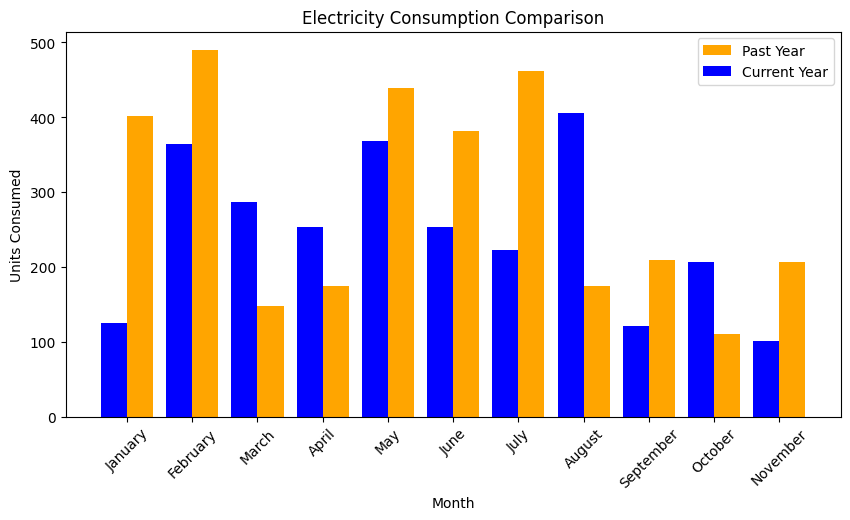

Bill saved as Bill_1.pdf


Press 1 for Download Pending Bill
Press 2 to Raise Complaint
Press any other key to Exit
Enter your choice:  2


----------------------------------------
Please provide the details for your complaint:


Enter Complaint Title:  dgsfguygfuyds
Enter Complaint Description:  cghjgjgjslscxjcbjhcj


Complaint submitted successfully!


Press 1 for Download Pending Bill
Press 2 to Raise Complaint
Press any other key to Exit
Enter your choice:  0


----------------------------------------

Exiting Customer Dashboard...


          Welcome To XYZ Billing System!!!
Enter Credentials To Proceed



KeyboardInterrupt: Interrupted by user

In [10]:
while True:
    print("\n" + "=" * 50)
    print(" " * 10 + "Welcome To XYZ Billing System!!!")
    print("=" * 50)
    print("Enter Credentials To Proceed\n")

    try:
        username = input("Enter Username: ").strip()
        pin = input("Enter Password: ").strip()

        user = CheckUser.login(username, pin)
        print("-" * 50)

        if user:
            if user.role == "customer":
                print("\nLogin Successful! Redirecting to Customer Dashboard...\n")
                customer = CustomerDashboard(user)
            else:
                print("\nLogin Successful! Redirecting to Admin Dashboard...\n")
                admin = AdminDashboard()
        else:
            print("\nInvalid credentials or user not found. Exiting...\n")
            break

    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}\n")
